In [82]:
from scipy import ndimage as ndi
from skimage import feature
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
import sys
from astropy.table import Table
sys.path.append("../")
sys.path.append("../analysis")
from scipy import signal
from gradkde import kde
from gradkde import kernels
import analysis_utils

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=15)
pl.rc('ytick', labelsize=15)
pl.rc('axes', labelsize=20)
pl.rc('axes', titlesize=30)
pl.rc('legend', handlelength=1)
pl.rc('legend', fontsize=15)

%matplotlib inline

In [3]:
import os
data = pd.DataFrame()
for file in os.listdir('../output/txtoutput'):
    print("reading file: {0}".format(file))
    data = data.append(pd.read_csv('../output/txtoutput/'+file, skiprows=1, delimiter='\t'))

reading file: out8.dat
reading file: out18.dat
reading file: out16.dat
reading file: out112.dat
reading file: out17.dat
reading file: out15.dat
reading file: out111.dat
reading file: out14.dat
reading file: out13.dat
reading file: out102.dat
reading file: out12.dat
reading file: out3.dat
reading file: out2.dat
reading file: out1.dat
reading file: out5.dat
reading file: out4.dat
reading file: out6.dat
reading file: out7.dat


In [143]:
k2dr2 = Table.read('../analysis/k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [145]:
len(df)

9755

In [144]:
import imp
imp.reload(analysis_utils)
ms = analysis_utils.selectms(
    df, 
    '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd', 
    bp_rp_range=(0.0, 5.0),
    g_rp_range=(0.0, 5.0),
    width=(-0.6, 0.6)
)

good_P = ms['P_mean'] / ms['P_sd'] > 15
good_P = good_P & (ms['P_mean'] < 32)
good_P = good_P & ((ms['logamp_mean'] - ms['logS0_mean']) > np.log(1e-3))
df = ms[good_P]

Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


In [69]:
from gradkde import kde
from gradkde import kernels
gauss = kernels.Gaussian()
kde1 = kde.KDE(gauss, 1.0, nderiv=0)
kde2 = kde.KDE(gauss, 1.0, nderiv=1)
kde1.condition(df['P_mean'])
kde2.condition(df['P_mean'])

In [112]:
color_mask = (df['g_rp'] > 0.8) & (df['g_rp'] < 1.05)
campaign_mask = df['k2_campaign_str'] == b'8'
p = df['P_mean'][color_mask & campaign_mask]
c = df['g_rp'][color_mask & campaign_mask]
f = lambda x, a, b, x0: a * (x - x0) + b * (x - x0)**0.5
upper =  7.30652737e+01, -4.59276655e+01, -1.05382282e-02
trend = f(c, *upper)
kde1.condition(p - trend)
kde2.condition(p - trend)
x = np.linspace(-30, 30, 1000)
y = kde1.evaluate(x)
dy = kde2.evaluate(x)

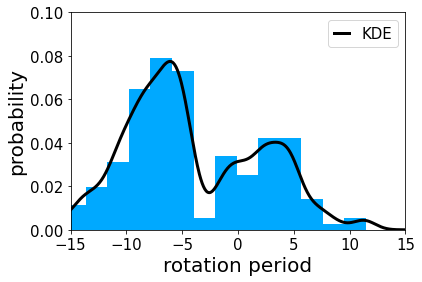

In [113]:
pl.hist(p - trend, bins=20, color=blue, density=True);
pl.plot(x, y, color='k', linewidth=3, label='KDE')
pl.ylabel("probability")
pl.xlabel("rotation period")
pl.xlim(-15, 15)
pl.ylim(-0.0, 0.1)
pl.legend()
#pl.savefig('figures/kde_c5_up.pdf')

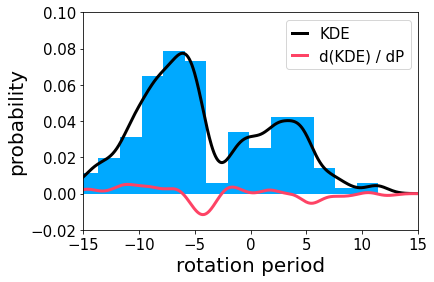

In [114]:
from scipy.signal import find_peaks
pl.hist(p - trend, bins=20, color=blue, density=True);
pl.plot(x, y, color='k', linewidth=3, label='KDE')
pl.plot(x, dy, color=red, linewidth=3, label='d(KDE) / dP')
pl.ylabel("probability")
pl.xlabel("rotation period")
pl.xlim(-15, 15)
pl.ylim(-0.02, 0.1)
pl.legend(loc='upper right')
#pl.savefig('figures/dkde_c5_up.pdf')

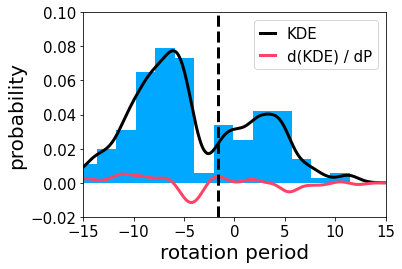

In [115]:
pl.hist(p - trend, bins=20, color=blue, density=True);
pl.plot(x, y, color='k', linewidth=3, label='KDE')
pl.plot(x, dy, color=red, linewidth=3, label='d(KDE) / dP')

peaks, res = find_peaks(dy[np.abs(x)<5], prominence=0.001)
peak = x[np.abs(x)<5][peaks[np.argmax(res['prominences'])]]
pl.axvline(peak, linestyle='--', color='k', linewidth=3)
#pl.axvspan(-100, -5, color='k', alpha=0.3)
#pl.axvspan(5, 100, color='k', alpha=0.3)

pl.ylabel("probability")
pl.xlabel("rotation period")
pl.xlim(-15, 15)
pl.ylim(-0.02, 0.1)
pl.legend(fontsize=15)
pl.subplots_adjust(left=0.2, bottom=0.17)
pl.savefig('/Users/tgordon/Desktop/peak_c8_up.pdf')

In [116]:
lower = 50.01095872, -34.1075594,   -0.16088571
trend = f(c, *lower)
kde1.condition(p - trend)
kde2.condition(p - trend)
x = np.linspace(-30, 30, 1000)
y = kde1.evaluate(x)
dy = kde2.evaluate(x)

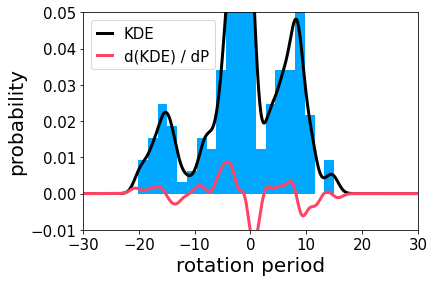

In [117]:
pl.hist(p - trend, bins=20, color=blue, density=True);
pl.plot(x, y, color='k', linewidth=3, label='KDE')
pl.plot(x, dy, color=red, linewidth=3, label='d(KDE) / dP')
pl.ylabel("probability")
pl.xlabel("rotation period")
pl.xlim(-30, 30)
pl.ylim(-0.01, 0.05)
pl.legend()
#pl.savefig('figures/dkde_c5_low.pdf')

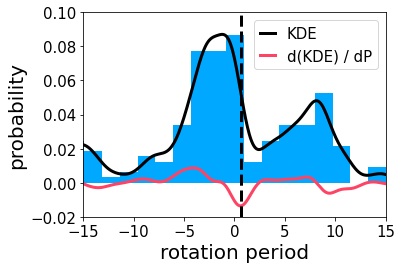

In [109]:
pl.hist(p - trend, bins=20, color=blue, density=True);
pl.plot(x, y, color='k', linewidth=3, label='KDE')
pl.plot(x, dy, color=red, linewidth=3, label='d(KDE) / dP')

peaks, res = find_peaks(-dy[np.abs(x)<5], prominence=0.001)
peak = x[np.abs(x)<5][peaks[np.argmax(res['prominences'])]]
pl.axvline(peak, color='k', linestyle='--', linewidth=3)
#pl.axvspan(-100, -5, color='k', alpha=0.3)
#pl.axvspan(5, 100, color='k', alpha=0.3)

pl.ylabel("probability")
pl.xlabel("rotation period")
pl.xlim(-15, 15)
pl.ylim(-0.02, 0.1)
pl.legend()

pl.subplots_adjust(left=0.2, bottom=0.17)
pl.savefig('/Users/tgordon/Desktop/peak_c8_low.pdf')